In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from HMM import unsupervised_HMM
from HMM import supervised_HMM
from HMM_helper import sample_sentence
from dtaidistance import dtw
from dtaidistance import clustering
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, leaves_list
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt


In [2]:
import git
import sys
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [3]:
def makeHMMUnSupData(Input, colname, fipsname):
    #Takes input dataframe, and gives out HMM format of data, a list of lists 
    #of the colname value, each list in the set represents one fips code.
    Output = []
    for fips in Input[fipsname].unique():
        temp = list(Input[Input[fipsname] == fips][colname])
        Output.append(temp)
    return Output

In [4]:
def makeHMMmap(Output):
    #Takes in output of makeHMMUnSupData and transforms data into list from 0 to D-1, where D is the number of unique
    #values of the output
    #Unqiue values in the input
    UniqueVals = np.array(list(set(x for l in Output for x in l)))
    UniqueVals = np.sort(UniqueVals)
    HMMOutput = []
    templs = []
    Map = {}
    RMap = {}
    for x in range(len(UniqueVals)):
        Map[int(UniqueVals[x])] = x
        RMap[x] = int(UniqueVals[x])
    for ls in Output:
        for val in ls:
            templs.append(Map[val])
        HMMOutput.append(templs)
        templs = []
    return [Map,RMap,HMMOutput]

In [5]:
def makeHMMSupData(UnSupData):
    #Takes list of lists of time series data from makeHMMUnSupData and makes it into data with X and Y
    X = []
    Y = []
    tempX = []
    tempY = []
    for ls in UnSupData:
        lenls = len(ls)
        for n in range(lenls):            
            if n == 0:
                tempX.append(ls[n])
            elif n == lenls - 1:
                tempY.append(ls[n])
            else:
                tempX.append(ls[n])
                tempY.append(ls[n])
        if len(tempX) != 0 and len(tempY) != 0:
            X.append(tempX)
            Y.append(tempY)
        tempX = []
        tempY = []   
    return [X,Y]

In [6]:
#Cumulative Death Data
NYT_tot = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties.csv")
NYT_tot = NYT_tot.drop(columns=['county','state']).sort_values(['fips','date']).reset_index(drop=True)
NYT_tot = NYT_tot.dropna(subset=['fips'])
NYT_tot['fips'] = NYT_tot.fips.astype(int)
NYT_tot['date'] = pd.to_datetime(NYT_tot['date'])
NYT_tot['id'] = NYT_tot.fips.astype(str).str.cat(NYT_tot.date.astype(str), sep=', ')
#Making new parameter for deathrate
NYT_tot['deathrate'] = NYT_tot['deaths']/NYT_tot['cases']
NYT_tot = NYT_tot.fillna(0)
#multiplying death rate by 1000 to give integer state values
NYT_tot['deathstate'] = NYT_tot['deathrate']*1000
NYT_tot['deathstate'] = NYT_tot['deathstate'].astype(int)

In [7]:
#Differenced Daily Death Data
NYT_daily = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
NYT_daily = NYT_daily.drop(columns=['county','state']).sort_values(['fips','date']).reset_index(drop=True)
NYT_daily['fips'] = NYT_daily.fips.astype(int)
NYT_daily['date'] = pd.to_datetime(NYT_daily['date'])
NYT_daily['id'] = NYT_daily.fips.astype(str).str.cat(NYT_daily.date.astype(str), sep=', ')
FirstDay = min(NYT_daily.date.unique())
LastDay = max(NYT_daily.date.unique())

In [8]:
#Making a time-warping of NYT daily data, so each county has a value at the starting day of 2020-01-21
# and then a final value at the most recent day
NYT_daily_Warp = NYT_daily
for fips in NYT_daily.fips.unique():
    rows = NYT_daily[NYT_daily['fips'] == fips]
    #adding in the first day values
    if FirstDay not in rows.date.unique():
        NYT_daily_Warp = NYT_daily_Warp.append({'fips': fips, 'date': pd.to_datetime('2020-01-21'), \
                               'cases': 0, 'deaths' : 0, 'id' : str(fips) + ', 2020-01-21'}, ignore_index=True)
    #making sure each entry has the final day values
    if LastDay not in rows.date.unique():
        NYT_daily_Warp = NYT_daily_Warp[NYT_daily_Warp['fips'] != fips]
NYT_daily_Warp = NYT_daily_Warp.sort_values(['fips','date']).reset_index(drop=True)

In [9]:
NYT_daily_Warp_Death = makeHMMUnSupData(NYT_daily_Warp, 'deaths', 'fips')

In [10]:
#This is a list of all the counties and dates
County_List = list(NYT_daily.fips.unique())
Date_List = list(NYT_daily.date.unique())
#This creates a base dataframe that contains all pairs of FIPS codes with the valid dates given in Air_Qual
CL, DL = pd.core.reshape.util.cartesian_product([County_List, Date_List])
BaseFrame = pd.DataFrame(dict(fips=CL, date=DL)).sort_values(['fips','date']).reset_index(drop=True)
BaseFrame['id'] = BaseFrame.fips.astype(str).str.cat(BaseFrame.date.astype(str), sep=', ')

In [11]:
#Making frame of all deaths at all dates to properly do DTW clustering
NYT_daily_Filled = BaseFrame.join(NYT_daily.set_index('id'), on='id', how='outer', lsuffix=''\
               ,rsuffix='_x').sort_values(['fips','date']).drop(columns=['fips_x','date_x']).fillna(0).drop_duplicates(subset=['fips','date']).reset_index(drop=True)

In [12]:
#List of lists of daily death count for each county, starting 1/23/20, ending most recent date.
NYT_daily_Death_Filled = makeHMMUnSupData(NYT_daily_Filled, 'deaths', 'fips')

In [13]:
#JHU Data
JHU_tot = pd.read_csv(f"{homedir}/data/us/covid/JHU_daily_US.csv").sort_values(['FIPS','Date'])
FIPSlist = JHU_tot.FIPS.unique()
Datelist = JHU_tot.Date.unique()
Datepair = [Datelist[0],Datelist[-1]]

In [14]:
#Getting rid of unneded fips code in the list of total codes
for fips in FIPSlist:
    rows = JHU_tot[JHU_tot['FIPS'] == fips]
    datelist = rows.Date.unique()
    datepair = [datelist[0],datelist[-1]]
    if np.array_equal(Datepair,datepair) != True:
        JHU_tot = JHU_tot.drop(list(JHU_tot[JHU_tot['FIPS'] == fips].index))
JHU_tot = JHU_tot.sort_values(['FIPS','Date']).reset_index(drop=True)

In [15]:
def monotonicCol(Data, colname):
    #Takes a column that should have monotonically increasing data for a column (number of deaths)
    #and adjusts the column to ensure this property, iterating backwards through each fips code's entries
    ls = []
    tempvals = []
    for fips in Data.FIPS.unique():
        vals = list(Data[Data['FIPS'] == fips][colname])
        flag = True
        for val in reversed(vals):
            if flag:
                flag = False
                maxval = val
                tempvals.append(maxval)
            else:
                if val > maxval:
                    tempvals.append(maxval)
                else:
                    maxval = val
                    tempvals.append(val)
        ls.extend(reversed(tempvals))
        tempvals = []
    return ls

In [16]:
d = {'FIPS': JHU_tot['FIPS'], 'Date' : JHU_tot['Date'], 'Confirmed' : monotonicCol(JHU_tot,'Confirmed'),\
       'Deaths' : monotonicCol(JHU_tot,'Deaths'),'Active' : monotonicCol(JHU_tot,'Active'), \
        'Recovered' : monotonicCol(JHU_tot,'Recovered')}
#Monotonically increaasing transformation of JHU_tot
JHU_mono = pd.DataFrame(data=d)

In [17]:
def cumtoDaily(Data, colname):
    #Takes cumulative column data and turns the data into daily changes 
    ls = []
    column = Data[colname]
    for fips in Data.FIPS.unique():
        ls.extend(list(Data[Data['FIPS'] == fips][colname].diff().fillna(0)))
    return ls

In [18]:
d = {'FIPS': JHU_mono['FIPS'], 'Date' : JHU_mono['Date'], 'Confirmed' : cumtoDaily(JHU_mono,'Confirmed'),\
       'Deaths' : cumtoDaily(JHU_mono,'Deaths'),'Active' : cumtoDaily(JHU_mono,'Active'), \
        'Recovered' : cumtoDaily(JHU_mono,'Recovered')}
#Daily changing data based on monotonically transformed data
JHU_daily = pd.DataFrame(data=d)

In [19]:
#List of lists of daily death count for each county, starting 3/23/20, ending most recent date.
JHU_daily_death = makeHMMUnSupData(JHU_daily, 'Deaths', 'FIPS')

In [20]:
#Our three types of death lists for DTW clusterings
NYT_daily_Warp_Death
NYT_daily_Death_Filled
JHU_daily_death

print(len(NYT_daily_Warp_Death))
print(np.mean([len(a) for a in NYT_daily_Warp_Death]))
print(np.mean([sum(a) for a in NYT_daily_Warp_Death]))
print(np.mean([np.mean(a) for a in NYT_daily_Warp_Death]))

print(len(NYT_daily_Death_Filled))
print(np.mean([len(a) for a in NYT_daily_Death_Filled]))
print(np.mean([sum(a) for a in NYT_daily_Death_Filled]))
print(np.mean([np.mean(a) for a in NYT_daily_Death_Filled]))

print(len(JHU_daily_death))
print(np.mean([len(a) for a in JHU_daily_death]))
print(np.mean([sum(a) for a in JHU_daily_death]))
print(np.mean([np.mean(a) for a in JHU_daily_death]))

2862
41.9727463312369
22.92557651991614
0.38403175504890397
2881
106.0
22.774383894481083
0.21485267824982152
2871
41.27307558342041
24.306513409961685
0.5528244012335326


In [21]:
def znormalize(ls):
#normalizes a list, if std=0 return the list
    std = np.std(ls)
    if std == 0.0:
        return np.array(ls)
    else:
        val = (ls - np.mean(ls))/np.std(ls)
        return (ls - np.mean(ls))/np.std(ls)

In [22]:
def znormalize_nozeros(ls):
#normalizes a list, if std=0 just pass
    std = np.std(ls)
    if std == 0.0:
        pass
    else:
        return (ls - np.mean(ls))/np.std(ls)

In [23]:
def noinf(arr):
    #Removes inf from list of lists
    newarr = []
    for x in arr:
        temp = x
        temp[temp == np.inf] = 9999
        newarr.append(x)
    return newarr

In [24]:
def nonzerofips(arr):
    #Takes in dataset, returns indices of data that do not have a list with all 0's
    ind = []
    for i in range(len(arr)):
        if np.std(arr[i]) != 0:
            ind.append(i)
    return ind

In [25]:
#Z normalization of our dataset
Series_NYT_W = [znormalize(x) for x in NYT_daily_Warp_Death]
Series_NYT_F = [znormalize(x) for x in NYT_daily_Death_Filled]
Series_JHU = [znormalize(x) for x in JHU_daily_death]

In [26]:
#Removal of Strictly 0 lists from our dataset, these will belong in cluster 0
Series_NYT_W_nozeros = [znormalize_nozeros(x) for x in NYT_daily_Warp_Death]
Series_NYT_W_nozeros =  [x for x in Series_NYT_W_nozeros if x is not None]

Series_NYT_F_nozeros = [znormalize_nozeros(x) for x in NYT_daily_Death_Filled]
Series_NYT_F_nozeros =  [x for x in Series_NYT_F_nozeros if x is not None]

Series_JHU_nozeros = [znormalize_nozeros(x) for x in JHU_daily_death]
Series_JHU_nozeros =  [x for x in Series_JHU_nozeros if x is not None]

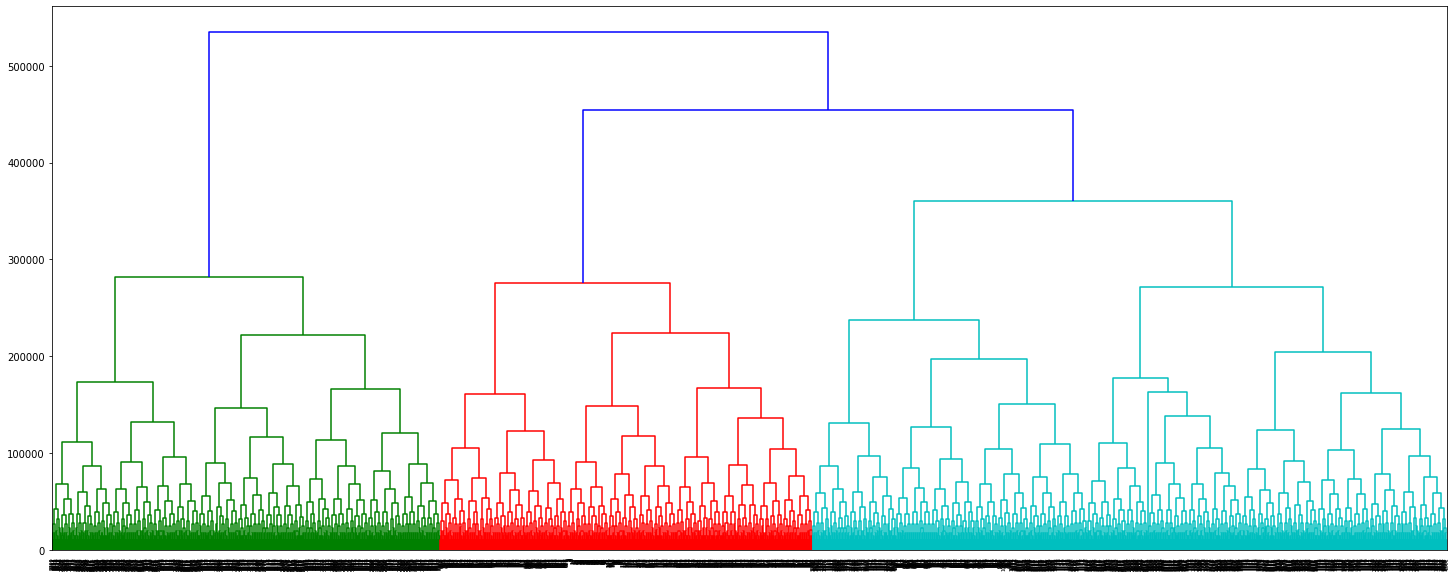

In [27]:
distance_JHU_O = dtw.distance_matrix_fast([np.array(a) for a in JHU_daily_death])
Z_JHU_O = linkage(noinf(distance_JHU_O), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_JHU_O = dendrogram(Z_JHU_O)


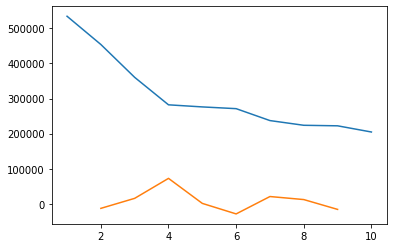

clusters: 4


In [28]:
last = Z_JHU_O[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [29]:
clusters_JHU_O = fcluster(Z_JHU_O, 4, criterion='maxclust')

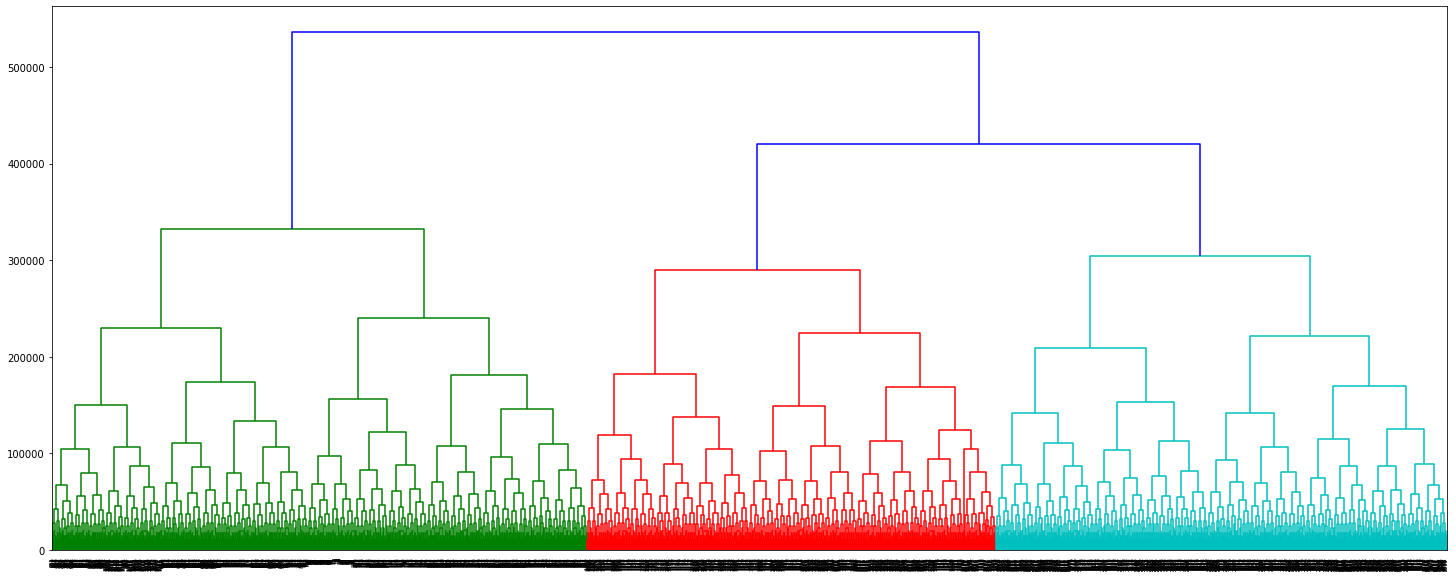

In [30]:
distance_NYT_F_O = dtw.distance_matrix_fast([np.array(a) for a in NYT_daily_Death_Filled])
Z_NYT_F_O = linkage(noinf(distance_NYT_F_O), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_F_O = dendrogram(Z_NYT_F_O)

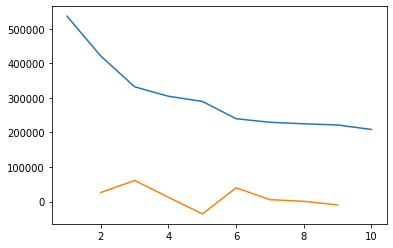

clusters: 3


In [31]:
last = Z_NYT_F_O[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [32]:
clusters_NYT_F_O = fcluster(Z_NYT_F_O, 3, criterion='maxclust')

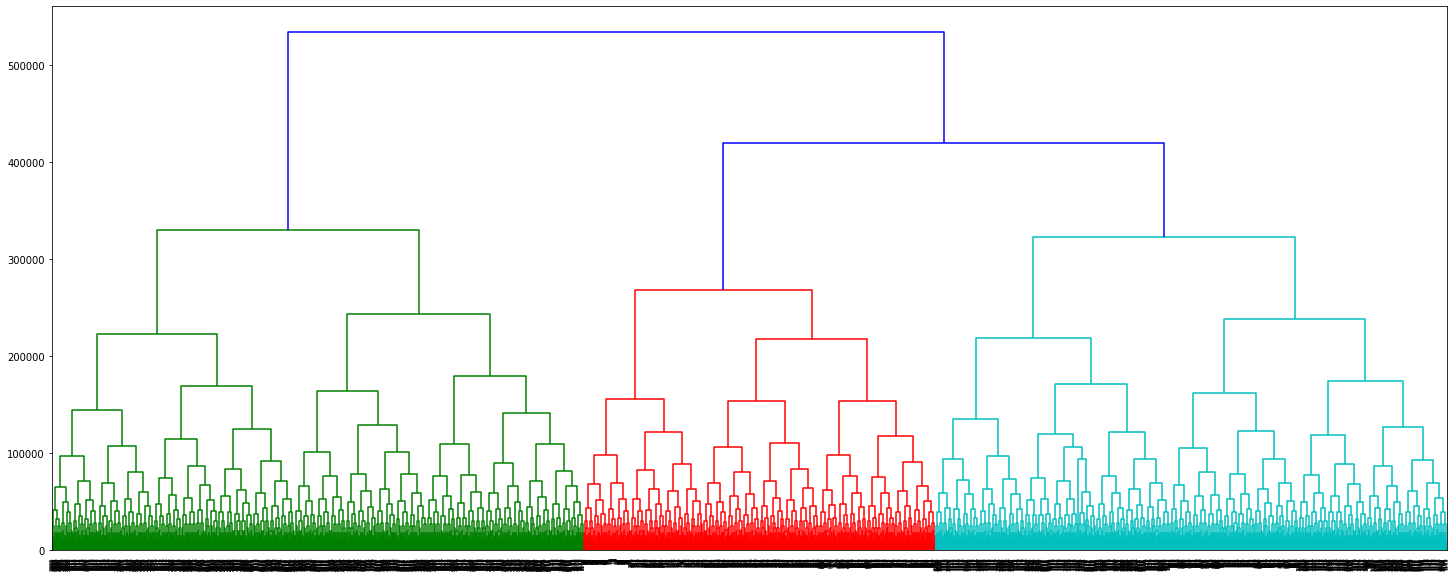

In [33]:
distance_NYT_W_O = dtw.distance_matrix_fast([np.array(a) for a in NYT_daily_Warp_Death])
Z_NYT_W_O = linkage(noinf(distance_NYT_W_O), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_W_O = dendrogram(Z_NYT_W_O)

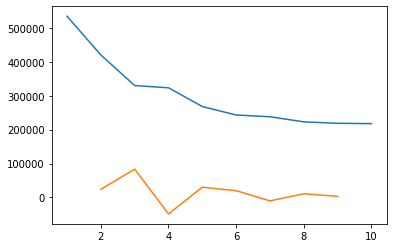

clusters: 3


In [34]:
last = Z_NYT_W_O[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [35]:
clusters_NYT_W_O = fcluster(Z_NYT_W_O, 3, criterion='maxclust')

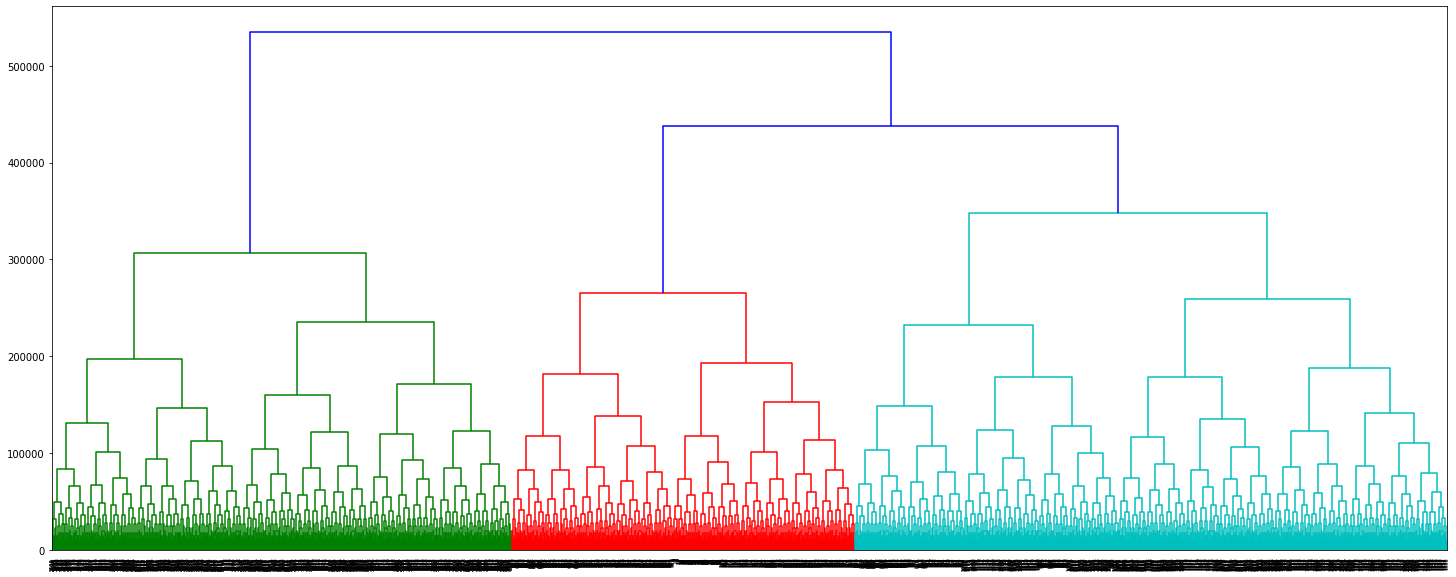

In [36]:
distance_JHU = dtw.distance_matrix_fast(Series_JHU)
Z_JHU = linkage(noinf(distance_JHU), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_JHU = dendrogram(Z_JHU)


In [37]:
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(Series_JHU)


In [38]:
print(cluster_idx)

None


In [34]:
last = Z_JHU[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


NameError: name 'Z_JHU' is not defined

In [38]:
clusters_JHU = fcluster(Z_JHU, 5, criterion='maxclust')

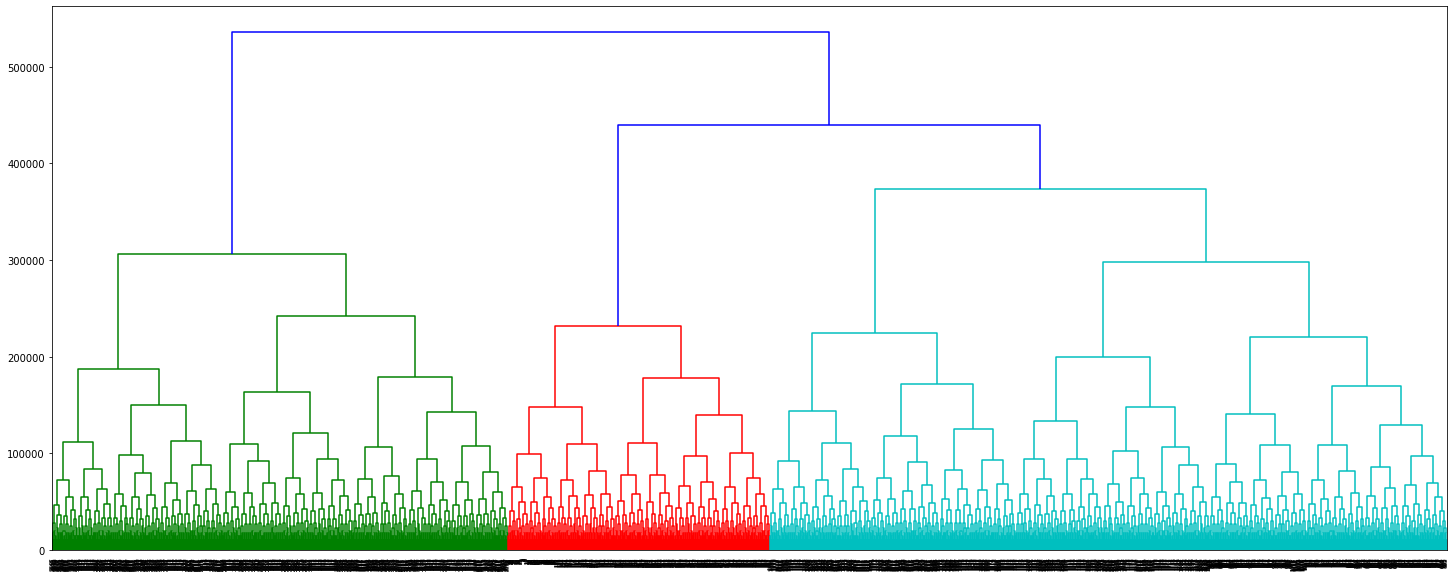

In [39]:
distance_NYT_F = dtw.distance_matrix_fast(Series_NYT_F)
Z_NYT_F = linkage(noinf(distance_NYT_F), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_F = dendrogram(Z_NYT_F)

In [173]:
Z_NYT_F

array([[2.30400000e+03, 2.30500000e+03, 9.98490479e+03, 2.00000000e+00],
       [2.40300000e+03, 2.40400000e+03, 9.98499236e+03, 2.00000000e+00],
       [2.16100000e+03, 2.16200000e+03, 9.98545828e+03, 2.00000000e+00],
       ...,
       [5.74500000e+03, 5.74800000e+03, 3.73133040e+05, 1.39600000e+03],
       [5.74600000e+03, 5.75000000e+03, 4.39448414e+05, 1.93600000e+03],
       [5.74900000e+03, 5.75100000e+03, 5.35743113e+05, 2.87700000e+03]])

In [27]:
x = dtw.distance_matrix_fast(Series_NYT_F)

In [31]:
x

array([[        inf,  4.4086671 , 10.9100754 , ..., 10.29563014,
        10.29563014,  4.42832788],
       [        inf,         inf, 11.29419731, ..., 10.29563014,
        10.29563014,  6.11991285],
       [        inf,         inf,         inf, ..., 10.29563014,
        10.29563014, 11.30860791],
       ...,
       [        inf,         inf,         inf, ...,         inf,
         0.        , 10.29563014],
       [        inf,         inf,         inf, ...,         inf,
                inf, 10.29563014],
       [        inf,         inf,         inf, ...,         inf,
                inf,         inf]])

In [28]:
v = squareform(x)

ValueError: Distance matrix 'X' must be symmetric.

In [ ]:
v

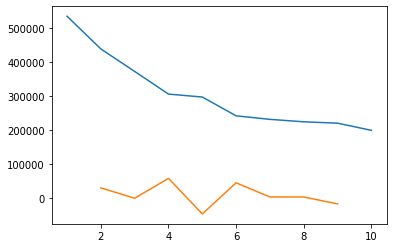

clusters: 4


In [40]:
last = Z_NYT_F[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [41]:
clusters_NYT_F = fcluster(Z_NYT_F, 4, criterion='maxclust')

In [170]:
for i in clusters_NYT_F:
    print(i)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


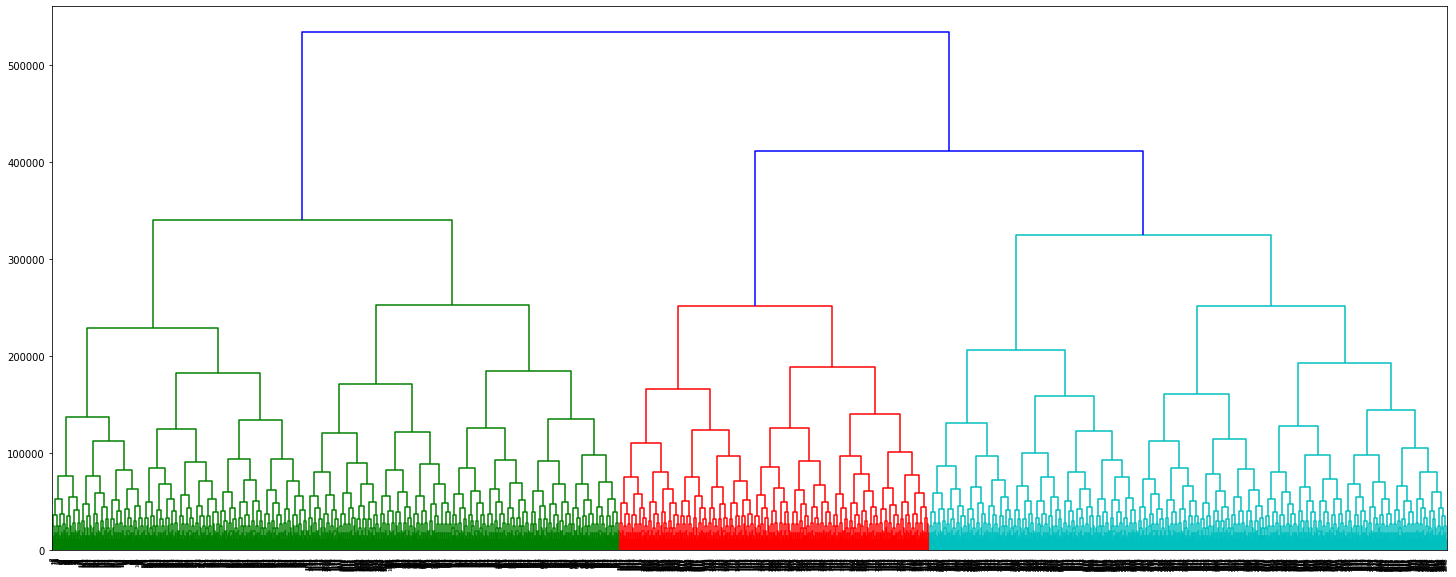

In [42]:
distance_NYT_W = dtw.distance_matrix_fast(Series_NYT_W)
Z_NYT_W = linkage(noinf(distance_NYT_W), 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z_NYT_W)

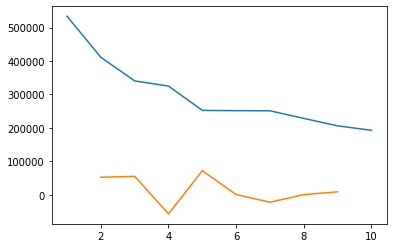

clusters: 5


In [43]:
last = Z_NYT_W[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [44]:
clusters_NYT_W = fcluster(Z_NYT_W, 5, criterion='maxclust')

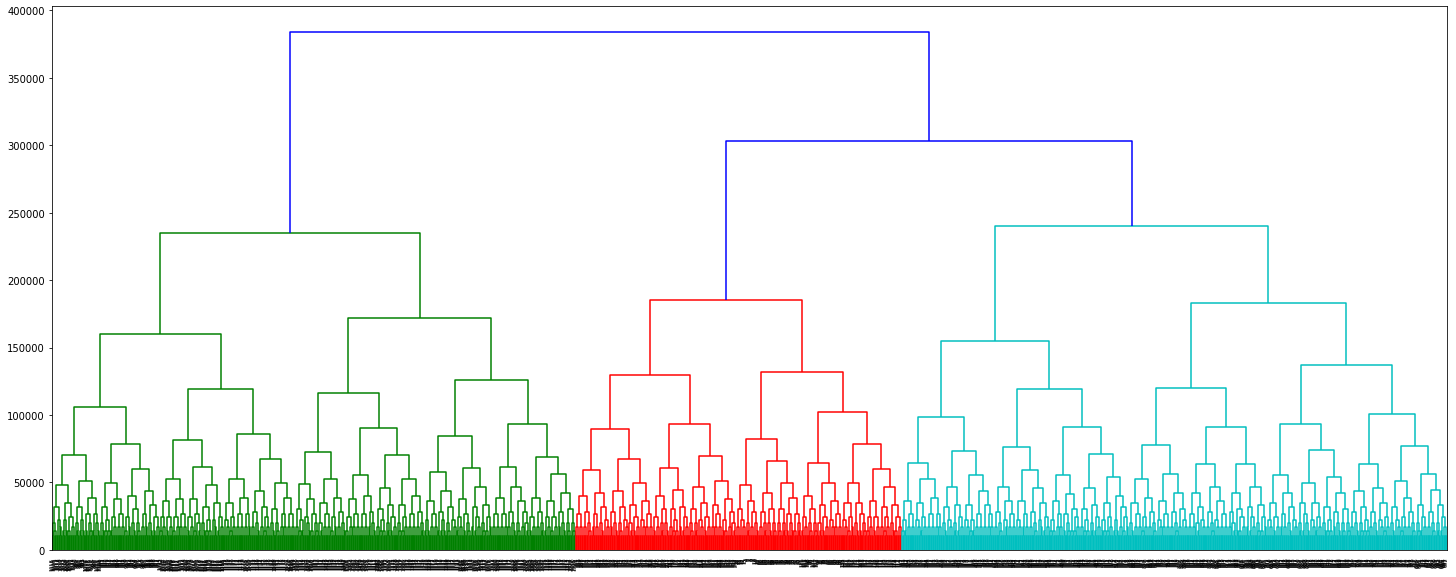

In [180]:
distance_JHU_N = dtw.distance_matrix_fast(Series_JHU_nozeros)
Z_JHU_N = linkage(noinf(distance_JHU_N), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_JHU_N = dendrogram(Z_JHU_N)

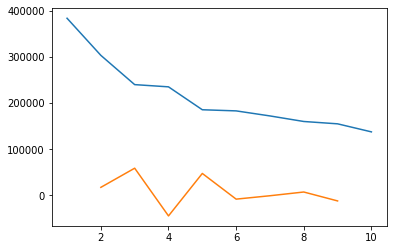

clusters: 3


In [177]:
last = Z_JHU_N[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [47]:
clusters_JHU_N = fcluster(Z_JHU_N, 5, criterion='maxclust')
temp = []
ind = nonzerofips(Series_JHU)
n = 0
for i in range(len(Series_JHU)):
    if i in ind:
        temp.append(clusters_JHU_N[n])
        n += 1
    else:
        temp.append(0)                  
clusters_JHU_N = temp

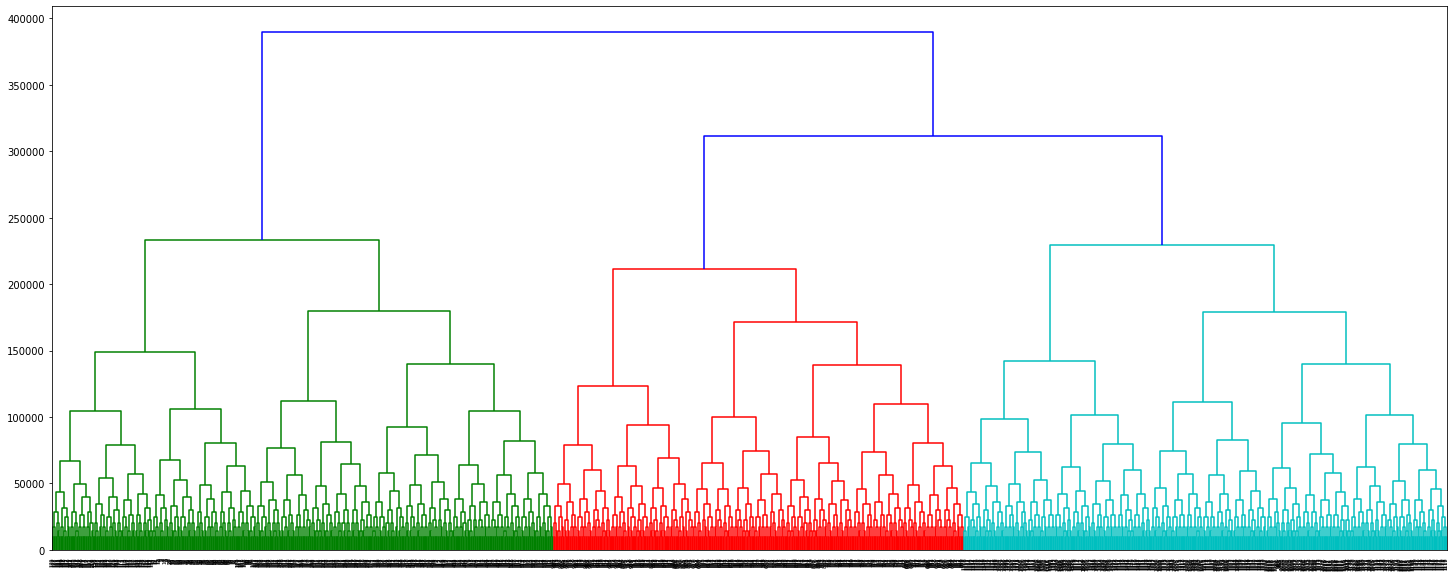

In [48]:
distance_NYT_F_N = dtw.distance_matrix_fast(Series_NYT_F_nozeros)
Z_NYT_F_N = linkage(noinf(distance_NYT_F_N), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_F_N = dendrogram(Z_NYT_F_N)

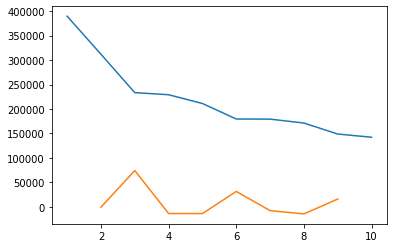

clusters: 3


In [49]:
last = Z_NYT_F_N[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [50]:
clusters_NYT_F_N = fcluster(Z_NYT_F_N, 3, criterion='maxclust')
temp = []
ind = nonzerofips(Series_NYT_F)
n = 0
for i in range(len(Series_NYT_F)):
    if i in ind:
        temp.append(clusters_NYT_F_N[n])
        n += 1
    else:
        temp.append(0)                  
clusters_NYT_F_N = temp

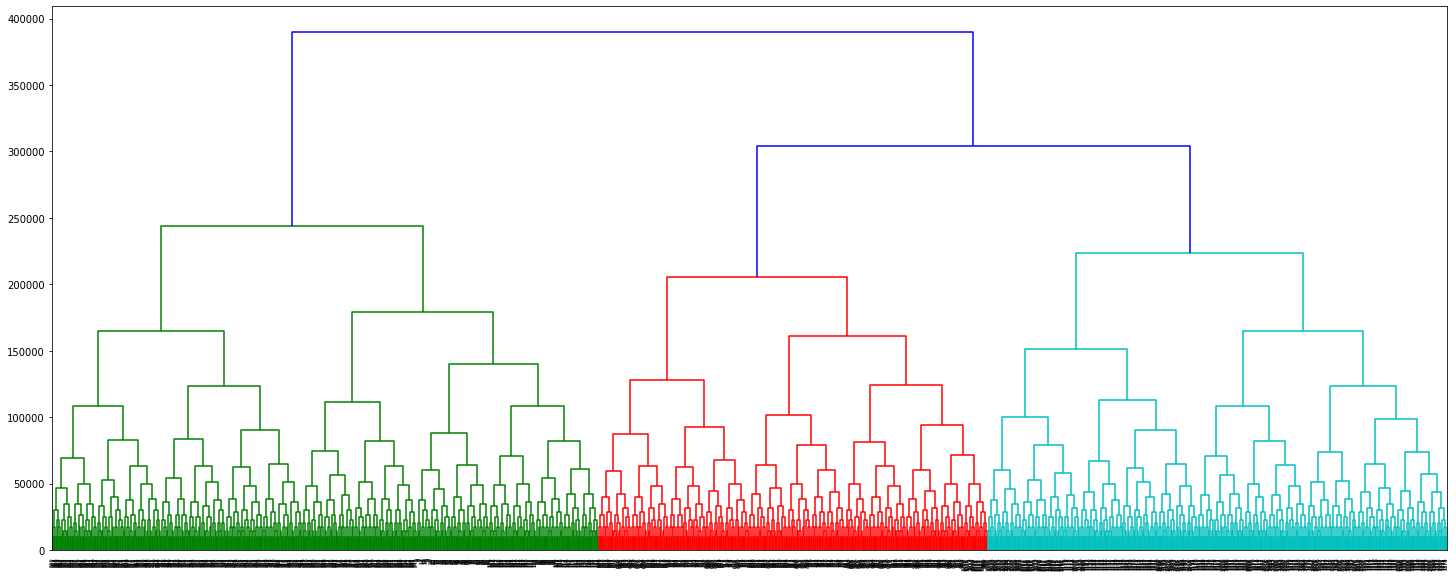

In [51]:
distance_NYT_W_N = dtw.distance_matrix_fast(Series_NYT_W_nozeros)
Z_NYT_W_N = linkage(noinf(distance_NYT_W_N), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_W_N = dendrogram(Z_NYT_W_N)

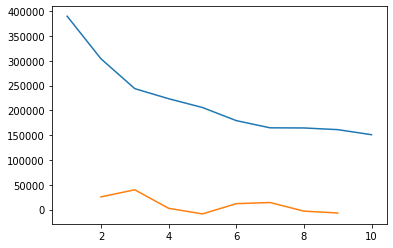

clusters: 3


In [52]:
last = Z_NYT_W_N[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [53]:
clusters_NYT_W_N = fcluster(Z_NYT_W_N, 3, criterion='maxclust')
temp = []
ind = nonzerofips(Series_NYT_W)
n = 0
for i in range(len(Series_NYT_W)):
    if i in ind:
        temp.append(clusters_NYT_W_N[n])
        n += 1
    else:
        temp.append(0)                  
clusters_NYT_W_N = temp

In [54]:
ClustersJHU = pd.DataFrame(data=JHU_daily.FIPS.unique(),columns=['FIPS'])
ClustersJHU['ZClusters'] = clusters_JHU
ClustersJHU['ZNClusters'] = clusters_JHU_N
ClustersJHU['OrigClusters'] = clusters_JHU_O

,FIPS,ZClusters,ZNClusters,OrigClusters
0,1001.0,3,3,2
1,1003.0,3,3,2
2,1005.0,3,3,2
3,1007.0,3,0,2
4,1009.0,3,0,2
5,1011.0,3,0,2
6,1013.0,3,3,2
7,1015.0,3,3,2
8,1017.0,3,3,2
9,1019.0,3,0,2


In [55]:
ClustersNYT_F = pd.DataFrame(data=NYT_daily_Filled.fips.unique(),columns=['FIPS'])
ClustersNYT_F['ZClusters_F'] = clusters_NYT_F
ClustersNYT_F['ZNClusters_F'] = clusters_NYT_F_N
ClustersNYT_F['OrigClusters_F'] = clusters_NYT_F_O

,FIPS,ZClusters_F,ZNClusters_F,OrigClusters_F
0,1001,2,1,1
1,1003,2,1,1
2,1005,2,1,1
3,1007,2,0,1
4,1009,2,0,1
5,1011,2,0,1
6,1013,2,1,1
7,1015,2,1,1
8,1017,2,1,1
9,1019,2,0,1


In [56]:
ClustersNYT_W = pd.DataFrame(data=NYT_daily_Warp.fips.unique(),columns=['FIPS'])
ClustersNYT_W['ZClusters_W'] = clusters_NYT_W
ClustersNYT_W['ZNClusters_W'] = clusters_NYT_W_N
ClustersNYT_W['OrigClusters_W'] = clusters_NYT_W_O

,FIPS,ZClusters_W,ZNClusters_W,OrigClusters_W
0,1001,1,1,2
1,1003,1,1,2
2,1005,1,1,2
3,1007,1,0,2
4,1009,1,0,2
5,1011,1,0,2
6,1013,1,1,2
7,1015,1,1,2
8,1017,1,1,2
9,1019,1,0,2


In [61]:
AllClusters = ClustersJHU.join(ClustersNYT_F.set_index('FIPS'), on='FIPS', \
                               how='outer').join(ClustersNYT_W.set_index('FIPS'), on='FIPS', how='outer').sort_values('FIPS')

In [62]:
AllClusters

,FIPS,ZClusters,ZNClusters,OrigClusters,ZClusters_F,ZNClusters_F,OrigClusters_F,ZClusters_W,ZNClusters_W,OrigClusters_W
0,1001.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
1,1003.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
2,1005.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
3,1007.0,3.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0
4,1009.0,3.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0
5,1011.0,3.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0
6,1013.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
7,1015.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
8,1017.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
9,1019.0,3.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0


In [168]:
AllClusters[AllClusters['ZClusters'] == 5]['FIPS']

1246    27035.0
1247    27037.0
1248    27039.0
1249    27041.0
1250    27043.0
1251    27045.0
1252    27047.0
1253    27049.0
1254    27051.0
1255    27053.0
1256    27055.0
1257    27059.0
1258    27061.0
1259    27063.0
1260    27065.0
1261    27067.0
1262    27069.0
1263    27071.0
1264    27073.0
1265    27079.0
1266    27081.0
1267    27083.0
1268    27085.0
1269    27087.0
1270    27089.0
1271    27091.0
1272    27093.0
1273    27095.0
1274    27097.0
1275    27099.0
         ...   
1889    39057.0
1890    39059.0
1891    39061.0
1892    39063.0
1893    39065.0
1894    39067.0
1895    39069.0
1896    39071.0
1897    39073.0
1898    39075.0
1899    39077.0
1900    39079.0
1901    39081.0
1902    39083.0
1903    39085.0
1904    39087.0
1905    39089.0
1906    39091.0
1907    39093.0
1908    39095.0
1909    39097.0
1910    39099.0
1911    39101.0
1912    39103.0
1913    39105.0
1914    39107.0
1915    39109.0
1916    39111.0
1917    39113.0
1918    39115.0
Name: FIPS, Length: 673,

In [132]:
SupHMM = []
Maplist = []
for i in AllClusters.ZClusters.dropna().unique():
    print(i)
    fips = list(AllClusters[AllClusters['ZClusters'] == i]['FIPS'])
    Rows = JHU_daily[JHU_daily['FIPS'].isin(fips)]
    UnSup = makeHMMUnSupData(Rows, 'Deaths', 'FIPS')
    [Map, RMap, UnSupHMM] = makeHMMmap(UnSup)
    Sup = makeHMMSupData(UnSupHMM)
    SupHMM.append(supervised_HMM(Sup[0],Sup[1]))
    Maplist.append(Map)


3.0
4.0
5.0
1.0
2.0


In [163]:
test = np.zeros(14)
for j in range(1000):
    test += np.array(sample_sentence(SupHMM[4], Maplist[4], 14, 2))
print(test/1000)
SupHMM

[0.85  0.455 0.235 0.254 0.172 0.198 0.153 0.1   0.148 0.127 0.122 0.18
 0.147 0.135]


In [83]:
DailyCaseUnSup = makeHMMUnSupData(NYT_daily, 'cases', 'fips')
DailyDeathUnSup = makeHMMUnSupData(NYT_daily, 'deaths', 'fips')

TotalCaseUnSup = makeHMMUnSupData(NYT_tot, 'cases', 'fips')
TotalDeathUnSup = makeHMMUnSupData(NYT_tot, 'deaths', 'fips')
TotalRateUnSup = makeHMMUnSupData(NYT_tot, 'deathstate', 'fips')

In [84]:
[DailyCaseMap, DailyCaseRMap, DailyCaseUnSupHMM] = makeHMMmap(DailyCaseUnSup)
[DailyDeathMap, DailyDeathRMap, DailyDeathUnSupHMM] = makeHMMmap(DailyDeathUnSup)

[TotalCaseMap, TotalCaseRMap, TotalCaseUnSupHMM] = makeHMMmap(TotalCaseUnSup)
[TotalDeathMap, TotalDeathRMap, TotalDeathUnSupHMM] = makeHMMmap(TotalDeathUnSup)
[TotalRateMap, TotalRateRMap, TotalRateUnSupHMM] = makeHMMmap(TotalRateUnSup)

In [85]:
DailyCaseSup = makeHMMSupData(DailyCaseUnSupHMM)
DailyDeathSup = makeHMMSupData(DailyDeathUnSupHMM)

TotalCaseSup = makeHMMSupData(TotalCaseUnSupHMM)
TotalDeathSup = makeHMMSupData(TotalDeathUnSupHMM)
TotalRateSup = makeHMMSupData(TotalRateUnSupHMM)

In [96]:
DailyDeathMap

{0.0: 0,
 1.0: 1,
 2.0: 2,
 3.0: 3,
 4.0: 4,
 5.0: 5,
 6.0: 6,
 7.0: 7,
 8.0: 8,
 9.0: 9,
 10.0: 10,
 11.0: 11,
 12.0: 12,
 13.0: 13,
 14.0: 14,
 15.0: 15,
 16.0: 16,
 17.0: 17,
 18.0: 18,
 19.0: 19,
 20.0: 20,
 21.0: 21,
 22.0: 22,
 23.0: 23,
 24.0: 24,
 25.0: 25,
 26.0: 26,
 27.0: 27,
 28.0: 28,
 29.0: 29,
 30.0: 30,
 31.0: 31,
 32.0: 32,
 33.0: 33,
 34.0: 34,
 35.0: 35,
 36.0: 36,
 37.0: 37,
 38.0: 38,
 39.0: 39,
 40.0: 40,
 41.0: 41,
 42.0: 42,
 43.0: 43,
 44.0: 44,
 45.0: 45,
 46.0: 46,
 47.0: 47,
 48.0: 48,
 49.0: 49,
 50.0: 50,
 51.0: 51,
 52.0: 52,
 53.0: 53,
 54.0: 54,
 55.0: 55,
 56.0: 56,
 57.0: 57,
 58.0: 58,
 59.0: 59,
 60.0: 60,
 61.0: 61,
 62.0: 62,
 63.0: 63,
 64.0: 64,
 65.0: 65,
 66.0: 66,
 67.0: 67,
 68.0: 68,
 69.0: 69,
 70.0: 70,
 71.0: 71,
 74.0: 72,
 75.0: 73,
 77.0: 74,
 78.0: 75,
 79.0: 76,
 80.0: 77,
 81.0: 78,
 82.0: 79,
 85.0: 80,
 87.0: 81,
 88.0: 82,
 91.0: 83,
 92.0: 84,
 93.0: 85,
 97.0: 86,
 98.0: 87,
 100.0: 88,
 102.0: 89,
 104.0: 90,
 105.0: 91,
 108

In [86]:
SupTest1 = supervised_HMM(DailyDeathSup[0],DailyDeathSup[1])

KeyboardInterrupt: 

In [ ]:
SupTest1

In [ ]:
sample_sentence(SupTest1, DailyDeathMap, 14, 8)

In [ ]:
test = np.zeros(14)
for i in range(1000):
    test += np.array(sample_sentence(SupTest1, DailyDeathMap, 14, 97))
test/1000

In [97]:
SupTest2 = supervised_HMM(TotalRateSup[0],TotalRateSup[1])

In [98]:
SupTest3 = supervised_HMM(DailyCaseSup[0],DailyCaseSup[1])

KeyboardInterrupt: 